In [2]:
from __future__ import division
import os
import math
import random
import scipy.stats as stats
import numpy as np
import seaborn as sns
import pymworks
import pickle
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/pymworks/protocol/__init__.py:15: UserWarning: networkx is required for pymworks.protocols.states
  warnings.warn('networkx is required for pymworks.protocols.states')


In [3]:
sns.set_style('ticks')

In [4]:
pickle_files_have_phases = False
bootstrap_iterations = 100

In [5]:
# filepaths of data to analyze

filepath1 = '_data/AK_Cohort/transparency_experiment/transparency/180625_to_180830/pickle_files_by_session/'
filepath2 = '_data/AK_Cohort/transparency_experiment/fullcross_before_transparency/180620_to_180624/pickle_files_by_session/'

In [6]:
def open_pickle_files_and_analyze(filepath):
    # get list of pickle file filenames in filepath
    dirs_list = [each for each in os.walk(filepath)]
    dirs_list = dirs_list[0][2] # capture only the pickle file filenames
    dirs_list = [i for i in dirs_list if i.startswith('.') == False] # remove hidden files

    # initiate dictionaries that will hold data
    results_by_session = {} # dictionary where keys will be animals, and values will be data
    sessions_by_animal = {} # dictionary where keys will be animals, and values will be session names

    # load the pickle files in the dirs_list one by one
    for filename in dirs_list:
        with open(filepath + filename, 'rb') as handle:
            data = pickle.load(handle)

        # for pickle files are sorted by phase and then session
        if pickle_files_have_phases == True:
            animal = data.keys()[0] # get animal name
            phases = sorted(data[animal].keys()) # get phases by that animal

            # notify the user of the sessions that are read
            print ' '
            print 'Read data from', animal, 'for...'
            for phase in phases:
                print 'phase:', phase, 'sessions:'
                sessions = data[animal][phase].keys()
                for session in sessions:
                    print session

            # lump sessions from all phases into one dictionary
            trials_grouped_by_session = {}
            for phase in data[animal].iterkeys():
                trials_grouped_by_session.update(data[animal][phase])
        
        # for pickle files are sorted by session only
        elif pickle_files_have_phases == False:
            animal = data.keys()[0]# get animal name

            # notify the user of the sessions that are read
            print ' '
            print 'Read data from', animal, 'for...'
            print 'sessions:'
            for session in sorted(data[animal].keys()):
                print session

            # lump sessions from all phases into one dictionary
            trials_grouped_by_session = data[animal]
        
        # then analyze
        result_by_session = get_data(animal, trials_grouped_by_session)
        results_by_session[animal] = result_by_session
        sessions_by_animal[animal] = result_by_session['avg_rt_success_by_session'].keys()

#         linegraph_per_animal(animal, result_by_session['avg_rt_success_by_session'], result_by_session['rt_success_error_by_session'])

#     meshed_data = mesh_data(results_by_session)

#     gauss_process = gaussian_process(meshed_data)

#     linegraph_all_animals(results_by_session)

    return results_by_session

def get_data(animal_name, trials_grouped_by_session):
    
    # ~~~~~~~~~ Capture trial data ~~~~~~~~~
    
    data_by_trial = trial_data(trials_grouped_by_session)
    rt_by_trial = data_by_trial['rt_by_trial']
    outcome_by_trial = data_by_trial['outcome_by_trial']
    iti_by_trial = data_by_trial['iti_by_trial']
    
    # ~~~~~~~~~ Capture session data ~~~~~~~~~
    
    data_by_session = session_data(trials_grouped_by_session)
    beh_outcome_by_session = data_by_session['beh_outcome_by_session']
    rt_by_session = data_by_session['rt_by_session']
    rt_success_by_session = data_by_session['rt_success_by_session']
    rt_failure_by_session = data_by_session['rt_failure_by_session']
    iti_by_session = data_by_session['iti_by_session']
    
    # ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

    avg_rt_success_by_session = average_data_rt(rt_success_by_session)
    avg_rt_failure_by_session = average_data_rt(rt_failure_by_session)
    avg_rt_by_session = average_data_rt(rt_by_session)

    rt_success_error_by_session = bootstrap_error_rt(rt_success_by_session, bootstrap_iterations)
    rt_failure_error_by_session = bootstrap_error_rt(rt_failure_by_session, bootstrap_iterations)
    rt_error_by_session = bootstrap_error_rt(rt_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~ Performance analysis ~~~~~~~~~~
    
    pct_correct_by_session = pct_correct(beh_outcome_by_session)
    
    bootstrap_error_by_session = bootstrap_error_perf(beh_outcome_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~~~ Session indices ~~~~~~~~~~~~

    norm_session_indices = [(x+1)/len(pct_correct_by_session) for x in range(len(pct_correct_by_session))]
    norm_session_indices = [(x+1)/len(avg_rt_success_by_session) for x in range(len(avg_rt_success_by_session))]

    data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'bootstrap_error_by_session': bootstrap_error_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_error_by_session': rt_success_error_by_session,
    'rt_failure_error_by_session': rt_failure_error_by_session,
    'rt_error_by_session': rt_error_by_session,
    'norm_session_indices': norm_session_indices
    }

    return data


# ~~~~~~~~~ Capture trial data ~~~~~~~~~

# get trial data in big lists across all sessions
def trial_data(trials_grouped_by_session):
    # initialize lists for trial data across all sessions
    rt = []
    outcome = []
    iti = []

    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            
            # only take into account the success or failure trials
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']:
               
                # append reaction time 
                rt.append(trials[trial_index]['reaction_time'])
                # append behavior outcome
                outcome.append(trials[trial_index]['behavior_outcome'])
                
                
                # intertrial interval analysis
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                    inter_trial_interval = next_stim_time - response_time
                    iti.append(inter_trial_interval)
                    
            # ignore the 'ignore' trials for now
            elif trials[trial_index]['behavior_outcome'] == 'ignore':
                pass 
          
    data_by_trial = {
    'rt_by_trial': rt,
    'outcome_by_trial': outcome,
    'iti_by_trial': iti
    }
    return data_by_trial

# ~~~~~~~~~ Capture session data ~~~~~~~~~

def session_data(trials_grouped_by_session):
    # initialize dictionaries for trial data by sessions
    beh_outcome_by_session = {}
    rt_by_session = {}
    rt_success_by_session = {}
    rt_failure_by_session = {}
    iti_by_session = {}
    
    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        session_rt_success = []
        session_rt_failure = []
        session_rt = []
        session_behavior_outcome = []
        session_iti = []
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            # behavior outcome and rt analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: # WITHOUT IGNORES
                session_rt.append(trials[trial_index]['reaction_time'])
                session_behavior_outcome.append(trials[trial_index]['behavior_outcome'])
                if trials[trial_index]['behavior_outcome'] == 'success':
                    session_rt_success.append(trials[trial_index]['reaction_time'])
                elif trials[trial_index]['behavior_outcome'] == 'failure':
                    session_rt_failure.append(trials[trial_index]['reaction_time'])
                    
            # intertrial interval analysis
            if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                session_iti.append(iti_for_first_trial)
            elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                next_stim_time = trials[trial_index]['stim_presentation_time']
                response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                inter_trial_interval = next_stim_time - response_time
                session_iti.append(inter_trial_interval)

        beh_outcome_by_session[session] = session_behavior_outcome
        rt_by_session[session] = session_rt
        rt_success_by_session[session] = session_rt_success
        rt_failure_by_session[session] = session_rt_failure
        iti_by_session[session] = session_iti
        
    data_by_session = {
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session
    }
    
    return data_by_session

# ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

def average_data_rt(data_by_session):
    avg_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]
        # if the session was empty, insert a NaN
        if len(data) > 0:
            avg = np.mean(data)
        elif len(data) == 0:
            avg = float('nan')
        avg_by_session[session] = avg
    return avg_by_session


def bootstrap_error_rt(data_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]

        # print 'data'
        # print data
        # print ' '

        total_trials = len(data)
        
        # print 'len(data)'
        # print len(data)
        # print ' '
        if total_trials > 0:
            list_of_avg = []
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(data, total_trials)
                avg = np.mean(r)
                list_of_avg.append(avg)
            mean_error = np.std(list_of_avg)
            bootstrap_error_by_session[session] = mean_error
        else:
            bootstrap_error_by_session[session] = float('nan')
    return bootstrap_error_by_session

# ~~~~~~~~~~ Performance analysis ~~~~~~~~~~

def pct_correct(beh_out_by_session):
    pct_correct_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['success'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_correct_by_session[session] = pct
    return pct_correct_by_session


def bootstrap_error_perf(beh_out_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['success'] / total_trials
                list_of_pct.append(pct)
            mean_error = np.std(list_of_pct)
        elif total_trials == 0:
            mean_error = float('nan')
        bootstrap_error_by_session[session] = mean_error
    return bootstrap_error_by_session

def mesh_data(results):
    d = {}
    for animal in results.keys():
        i = results[animal]['norm_session_indices'] # indexed session list comes pre-made from get_data_for_figure()
        y = []
        y_data = results[animal]['avg_rt_success_by_session']
        for session in sorted(y_data.iterkeys()):
            y.append(y_data[session])
        d[animal] = {'i': i, 'y': y}

    all_y = []
    all_i = []
    for a in d.iterkeys():
        # print 'key = ' + a
        if len(all_i) == 0:
            # print 'in if statement'
            all_i = d[a]['i']
            all_y = d[a]['y']
            # print all_i
            # print all_x
        else:
            # print 'in else statement'
            for j in range(len(d[a]['i'])):
                # print 'first for loop'
                for i in range(len(all_i)):
                    # print 'second for loop'
                    if all_i[i] >= d[a]['i'][j]:
                        #print 'first half'
                        #print all_x[:i]
                        all_i = all_i[:i] + [d[a]['i'][j]] + all_i[i:]
                        all_y = all_y[:i] + [d[a]['y'][j]] + all_y[i:]
                        # print all_i
                        # print all_x
                        break

    # print 'all_x:', all_x
    # print ' '
    # print 'all_i:', all_i

    meshed_data = {'all_i': all_i, 'all_y': all_y}

    return meshed_data

In [7]:
results_by_session_transp = open_pickle_files_and_analyze(filepath1)

 
Read data from AK10_transparent0.1 for...
sessions:
AK10_180625transparency0.1.mwk
AK10_180626transparency0.1.mwk
AK10_180627transparency0.1.mwk
AK10_180628transparency0.1.mwk
AK10_180629transparency0.1.mwk
AK10_180824transparency0.1.mwk
AK10_180825transparency0.1.mwk
AK10_180827transparency0.1.mwk
AK10_180828transparency0.1.mwk
AK10_180829transparency0.1.mwk
AK10_180830transparency0.1.mwk
 
Read data from AK11_transparent0.0 for...
sessions:
AK11_180625transparency0.0.mwk
AK11_180626transparency0.0.mwk
AK11_180627transparency0.0.mwk
AK11_180628transparency0.0.mwk
AK11_180629transparency0.0.mwk
AK11_180824transparency0.0.mwk
AK11_180825transparency0.0.mwk
AK11_180827transparency0.0.mwk
AK11_180828transparency0.0.mwk
AK11_180829transparency0.0.mwk
AK11_180830transparency0.0.mwk
 
Read data from AK12_transparent0.1 for...
sessions:
AK12_180625transparency0.1.mwk
AK12_180626transparency0.1.mwk
AK12_180627transparency0.1.mwk
AK12_180628transparency0.1.mwk
AK12_180629transparency0.1.mwk
A

In [8]:
results_by_session_fullcross_before = open_pickle_files_and_analyze(filepath2)

 
Read data from AK10 for...
sessions:
AK10_180620.mwk
AK10_180621.mwk
AK10_180622.mwk
AK10_180623.mwk
AK10_180624.mwk
 
Read data from AK11 for...
sessions:
AK11_180620.mwk
AK11_180621.mwk
AK11_180622.mwk
AK11_180623.mwk
AK11_180624.mwk
 
Read data from AK12 for...
sessions:
AK12_180620.mwk
AK12_180621.mwk
AK12_180622.mwk
AK12_180623.mwk
AK12_180624.mwk
 
Read data from AK1 for...
sessions:
AK1_180620.mwk
AK1_180622.mwk
AK1_180623.mwk
AK1_180624.mwk
 
Read data from AK2 for...
sessions:
AK2_180620.mwk
AK2_180621.mwk
AK2_180622.mwk
AK2_180623.mwk
AK2_180624.mwk
 
Read data from AK3 for...
sessions:
AK3_180620.mwk
AK3_180621.mwk
AK3_180622.mwk
AK3_180623.mwk
AK3_180624.mwk
 
Read data from AK5 for...
sessions:
AK5_180620.mwk
AK5_180621.mwk
AK5_180622.mwk
AK5_180623.mwk
AK5_180624.mwk
 
Read data from AK6 for...
sessions:
AK6_180620.mwk
AK6_180621.mwk
AK6_180622.mwk
AK6_180623.mwk
AK6_180624.mwk
 
Read data from AK7 for...
sessions:
AK7_180621.mwk
AK7_180622.mwk
AK7_180623.mwk
AK7_180624

In [9]:
relevant_data = 'avg_rt_success_by_session'

# create generic dictionary names to make the for loop more general for different data filenames
data_dict1 = results_by_session_transp
data_dict2 = results_by_session_fullcross_before

relevant_data_dict1 = {}
relevant_data_dict2 = {}

# extract the relevant_data from the data_dicts and place in new dictionaries
for animal in data_dict1.iterkeys():
    for session in sorted(data_dict1[animal][relevant_data]):
        try:
            relevant_data_dict1[animal].append(data_dict1[animal][relevant_data][session])
        except KeyError:
            relevant_data_dict1[animal] = [data_dict1[animal][relevant_data][session]]
            
for animal in data_dict2.iterkeys():
    for session in sorted(data_dict2[animal][relevant_data]):
        try:
            relevant_data_dict2[animal].append(data_dict2[animal][relevant_data][session])
        except KeyError:
            relevant_data_dict2[animal] = [data_dict2[animal][relevant_data][session]]
            

transp_RTs = relevant_data_dict1
fullcross_RTs = relevant_data_dict2

In [10]:
transp_RTs.keys()[0].split('_')[0]

'AK7'

In [11]:
isolate_animals = True # isolate animals in transparency0.0 or transparency0.1 groups

transp_mean_RTs = []
fullcross_mean_RTs = []
animals = []


# isolate animals in transparency0.0 or transparency0.1 groups
condition = '0.0' # change this to 0.1 or 0.0 depending on which group to exclude (choose opposite of group to include)
if isolate_animals == True:
    animals_excluded = [i for i in transp_RTs.keys() if condition not in i]
else:
    animals_excluded = []

# if using limited number of sessions at ends
sessions_to_count = 2


for animal in sorted(transp_RTs.keys()):
    if animal not in animals_excluded:
        animals.append(animal)
        transp_mean_RTs.append(np.mean(transp_RTs[animal][-sessions_to_count:])) # take last sessions_to_count sessions
        # here fullcross has different animal names because don't have "transparent0.n" tag, so split the animal name string to use as a key
        fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal.split('_')[0]][-sessions_to_count:])) # take last sessions_to_count sessions
    else:
        pass
    
# # if using all stimB sessions, take equivalent number of fullcross sessions

# for animal in sorted(stimB_RTs.keys()):
#     animals.append(animal)
#     stimB_mean_RTs.append(np.mean(stimB_RTs[animal]))
#     fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-len(stimB_RTs[animal]):]))

## Change in RT from baseline

AK10_transparent0.1
AK11_transparent0.0
AK1_transparent0.0
AK2_transparent0.1
AK3_transparent0.0
AK6_transparent0.0
AK7_transparent0.0
AK9_transparent0.1


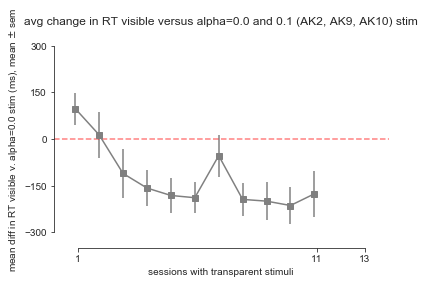

In [100]:
# Plot change in RT from baseline for this condition

transp_RTs
fullcross_RTs

# transp_mean_RTs
# fullcross_mean_RTs

sessions_to_count = 2
condition = '0.0'

diffs = []
for animal in sorted(transp_RTs.keys()):
    if condition in animal or 'AK2' in animal or 'AK9' in animal or 'AK10' in animal:
        print animal
        diff = [i - np.mean(fullcross_RTs[animal.split('_')[0]][-sessions_to_count:]) for i in transp_RTs[animal]]
        diffs.append(diff)

#         y = diff
#         x = [i+1 for i in range(len(y))]
#         plt.plot(x,y, label = animal, color = 'gray', alpha = 0.5)
    else:
        pass


diff_lengths = []
for l in diffs:
    diff_lengths.append(len(l))

# n_of_sessions = 13
# for i in range(len(diffs)):
#     diffs[i] = diffs[i][:n_of_sessions]
    

diffs_avg = np.average(diffs, axis = 0)
std = np.std(diffs, axis = 0)
sem = std / math.sqrt(len(diffs_avg))

y = diffs_avg
x = [i+0.9 for i in range(len(y))]
     

plt.errorbar(x, y, marker = 's', yerr = sem, color = 'gray')

plt.ylim(-350, 350)
plt.yticks([-300,-150,0,150,300])
plt.xlim(0, 14)
plt.xticks([1,11,13])
plt.axhline(y = 0, linestyle = '--', color = 'r', alpha = 0.5)
plt.xlabel('sessions with transparent stimuli')
plt.ylabel('mean diff in RT visible v. alpha=0.0 stim (ms), mean $\pm$ sem')
# plt.ylabel('diff in RT visible v. alpha=0.0 stim (ms)')
plt.title('avg change in RT visible versus alpha=0.0 and 0.1 (AK2, AK9, AK10) stim')
sns.despine(trim = True)
plt.savefig('_graphs_reg_v_transp_stim/AKs_avg_change_in_RT_visiblebaseline_v_alpha00_and_alpha01_AK2_AK9_AK10_stim_longer_SEM.pdf')

In [99]:
# Permutation test

transposed_diffs = np.transpose(diffs) # diffs sorted by animal, this sorts it by session instead
p_vals_by_session = []

nreps = 2**len(diffs) # number of permutatitions is 2^n

# not very efficient method of finding all the permutations, but it's ok while 2^n is small
sign_dist = []
while len(sign_dist) < nreps:
    sign = [random.choice([-1, 1]) for i in range(len(diffs))]
    if sign not in sign_dist:
        sign_dist.append(sign)
    else:
        pass

for j in transposed_diffs:
    means = []
    for i in range(nreps):
        perm = np.multiply(j, sign_dist[i])
        perm_mean = np.mean(perm)
        means.append(perm_mean)
        
    hits = 0
    for m in means:
        if m >= abs(np.mean(j)): # two-sided test
            hits += 1
        else:
            pass
    p_val = hits/len(means)
    
    p_vals_by_session.append(p_val)

print p_vals_by_session

[0.0859375, 0.44921875, 0.15625, 0.03125, 0.02734375, 0.015625, 0.26953125, 0.02734375, 0.03125, 0.01953125, 0.0546875]


## First Session (1st and 2nd half)

<ErrorbarContainer object of 3 artists>

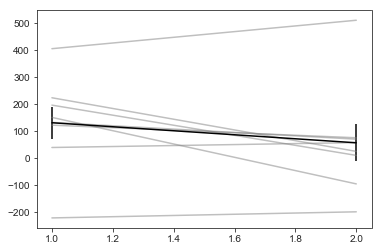

In [103]:
sessions_to_count = 2
condition = '0.0'

diffs = []
for animal in sorted(results_by_session_transp.keys()):
    diffs1 = []
    diffs2 = []
#     if condition in animal or 'AK2' in animal or 'AK9' in animal: # in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
    if condition in animal or 'AK2' in animal or 'AK9' in animal or 'AK10' in animal: 
        diff1 = first_half_all[animal] - np.mean(fullcross_RTs[animal.split('_')[0]][-sessions_to_count:])
        diff2 = second_half_all[animal] - np.mean(fullcross_RTs[animal.split('_')[0]][-sessions_to_count:])
        diffs1.append(diff1)
        diffs2.append(diff2)
        
        diff = [i - np.mean(fullcross_RTs[animal.split('_')[0]][-sessions_to_count:]) for i in first_session_halved[animal]]
        diffs.append(diff)
        
        y = diff
        x = [i+1 for i in range(len(y))]
        plt.plot(x, y, label = animal, color = 'gray', alpha = 0.5)
    else:
        pass
    
diffs_avg = np.average(diffs, axis = 0)
std = np.std(diffs, axis = 0)
sem = std / math.sqrt(len(diffs))

y = diffs_avg
x = [i+1 for i in range(len(y))]
              
plt.errorbar(x, y, yerr = sem, color = 'k')

In [104]:
transposed_diffs = np.transpose(diffs)

nreps = 2**len(diffs) # number of permutatitions is 2^n

# not very efficient method of finding all the permutations, but it's ok while 2^n is small
sign_dist = []
while len(sign_dist) < nreps:
    sign = [random.choice([-1, 1]) for i in range(len(diffs))]
    if sign not in sign_dist:
        sign_dist.append(sign)
    else:
        pass

p_vals_by_session = []
for j in transposed_diffs:
    means = []
    for i in range(nreps):
        perm = np.multiply(j, sign_dist[i])
        perm_mean = np.mean(perm)
        means.append(perm_mean)

    hits = 0
    for m in means:
        if m >= abs(np.mean(j)): # two-sided test
            hits += 1
        else:
            pass
    p_val = hits/len(means)

    p_vals_by_session.append(p_val)

print p_vals_by_session

[0.0390625, 0.2890625]


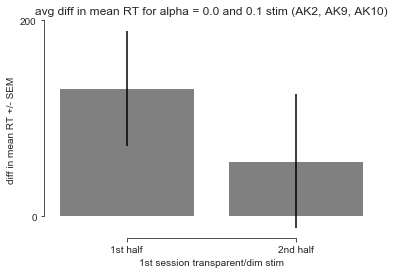

In [111]:
objects = ('1st half', '2nd half')
y_pos = np.arange(len(objects))
plt.bar(y_pos, diffs_avg, yerr = sem, align = 'center', color = 'gray')
plt.xticks(y_pos, objects)
plt.yticks([0, 200])
plt.ylabel('diff in mean RT +/- SEM')
plt.xlabel('1st session transparent/dim stim')
plt.title('avg diff in mean RT for alpha = 0.0 and 0.1 stim (AK2, AK9, AK10)')
sns.despine(trim = True)
plt.savefig('avg_diff_in_mean_RT_1st_session_alpha00_all_and_alpha01_for_AK2_AK9_AK10.pdf')